In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

import os
from matplotlib.colors import LinearSegmentedColormap

sns.set_theme(style="darkgrid")



In [2]:
def data_preparation_for_ut(data_,feature):
    #Considering only one plane
    
    # data_ = data[data.Sector.str.startswith('UTaX')][['Staves','Rows','PedestalValue']]

    # data_ = data[['Staves','Rows','PedestalValue']]


    data_ = data_.groupby(['Staves','Rows']).agg('mean').reset_index()
    data_.head()

    #Providing the actual order of the UT-Detector
    row_order = ['S4T','M4T','S3T','M3T','S2T','M2T','S1T','M1T','M1B','S1B','M2B','S2B','M3B','S3B','M4B','S4B']
    stave_order = ['1C', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '8A', '7A', '6A', '5A', '4A', '3A', '2A', '1A']

    data_['Rows'] = pd.Categorical(data_['Rows'], categories=row_order, ordered=True)
    data_['Staves'] = pd.Categorical(data_['Staves'], categories=stave_order, ordered=True)


    data_ = data_.pivot(index='Rows', columns='Staves', values=feature)
    return data_




custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["green", "orange", "red"])

#Plotting UT Plane
def ut_plot(data_,path=None,filename=None,save_fig=False,show_fig=False,vmin_vmax_scaled=False):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    if vmin_vmax_scaled:
        # sns.heatmap(data_, cmap=custom_cmap, cbar=True, linewidths=0.5, linecolor='black',vmin=0,vmax=0.000005) #This is for KLDiv ToyData
        sns.heatmap(data_, cmap=custom_cmap, cbar=True, linewidths=0.5, linecolor='black',vmin=0,vmax=1) #This is for KLRealRunData
    else:
        sns.heatmap(data_, cmap=custom_cmap, cbar=True, linewidths=0.5, linecolor='black')

    # Get the center row and column
    center_row, center_col = data_.shape[0] // 2, data_.shape[1] // 2

    # Add the central horizontal and vertical lines
    plt.axhline(y=center_row, color='black', linewidth=2)  # Horizontal Line
    plt.axvline(x=center_col, color='black', linewidth=2)  # Vertical Line

    # Plot the four lines around the center
    plt.plot([center_col-1, center_col+1], [center_row-1, center_row-1], color='black', linewidth=1.5)
    plt.plot([center_col-1, center_col+1], [center_row+1, center_row+1], color='black', linewidth=1.5)
    plt.plot([center_col-1, center_col-1], [center_row-1, center_row+1], color='black', linewidth=1.5)
    plt.plot([center_col+1, center_col+1], [center_row-1, center_row+1], color='black', linewidth=1.5)

    # Add titles and labels
    #UTaX is getting filtered from data_preparation_for_ut function
    plt.title("Heatmap of UTaX")
    plt.xlabel('Staves')
    plt.ylabel('Rows')

    # Save or show the plot
    if save_fig:
        os.makedirs(path, exist_ok=True)
        plt.savefig(f'{path}/{filename}.png')
    if show_fig:
        plt.show()

    # Close the plot
    plt.close()



In [3]:
data = pd.read_parquet('./Data/FullData.parquet')

numbers = [293528, 293530, 293532, 293533, 297288, 298593, 298594, 298595, 298596, 302935]

data = data.loc[data.RunNumber.isin(numbers)]

data.RunNumber = data.RunNumber.astype('category')

data = data[data.Sector.str.startswith('UTaX')]


# data = data[['RunNumber','Sector','Staves','Rows','PedestalValue']]

data = data[['RunNumber','Staves','Rows','PedestalValue']]

print(data.shape)
data.head()

(1269760, 4)


,RunNumber,Staves,Rows,PedestalValue
0,293532,1C,S4B,-7
1,293532,1C,S4B,-7
2,293532,1C,S4B,-6
3,293532,1C,S4B,-5
4,293532,1C,S4B,-5


In [4]:
pedestal = data.groupby(['RunNumber',  'Staves', 'Rows'], as_index=False)['PedestalValue'].mean()

<Axes: xlabel='PedestalValue', ylabel='Count'>

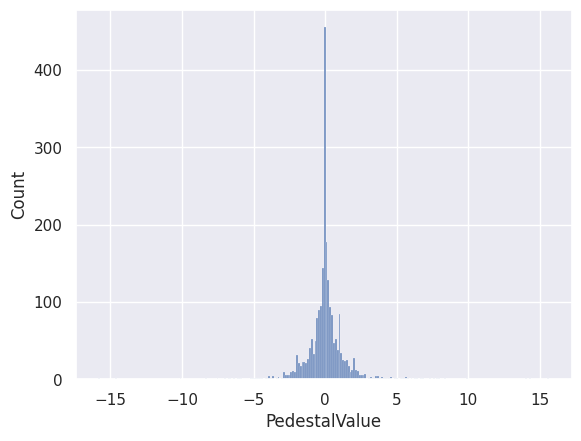

In [5]:
sns.histplot(pedestal['PedestalValue'])

In [6]:
pedestal['PedestalValue'] = pedestal['PedestalValue'].fillna(method='ffill')

In [7]:
class SequenceDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



np.random.seed(40)
seq_length = 256


train_data = pedestal[:-256*2]
test_data = pedestal[-256*2:]

train_data['PedestalValue'] = scaler.fit_transform(train_data[['PedestalValue']])
test_data['PedestalValue'] = scaler.transform(test_data[['PedestalValue']])


train_dataset = SequenceDataset(train_data['PedestalValue'].values, seq_length)
test_dataset = SequenceDataset(test_data['PedestalValue'].values, seq_length)

# Use DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

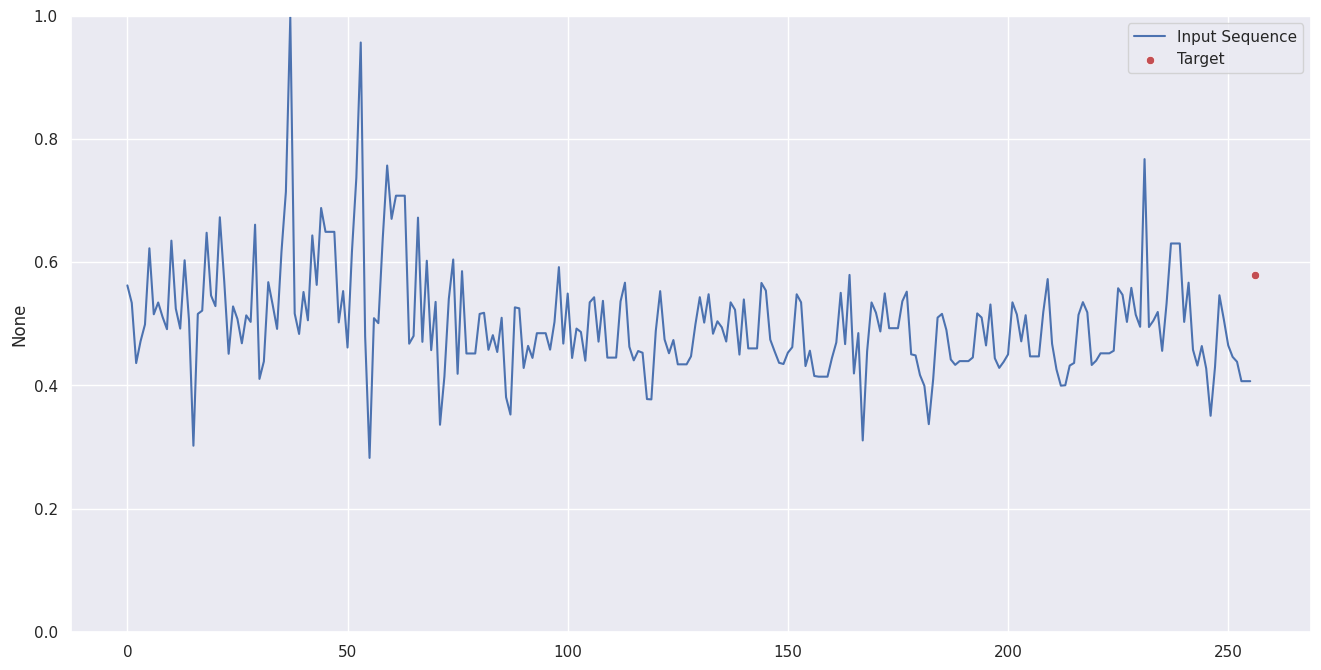

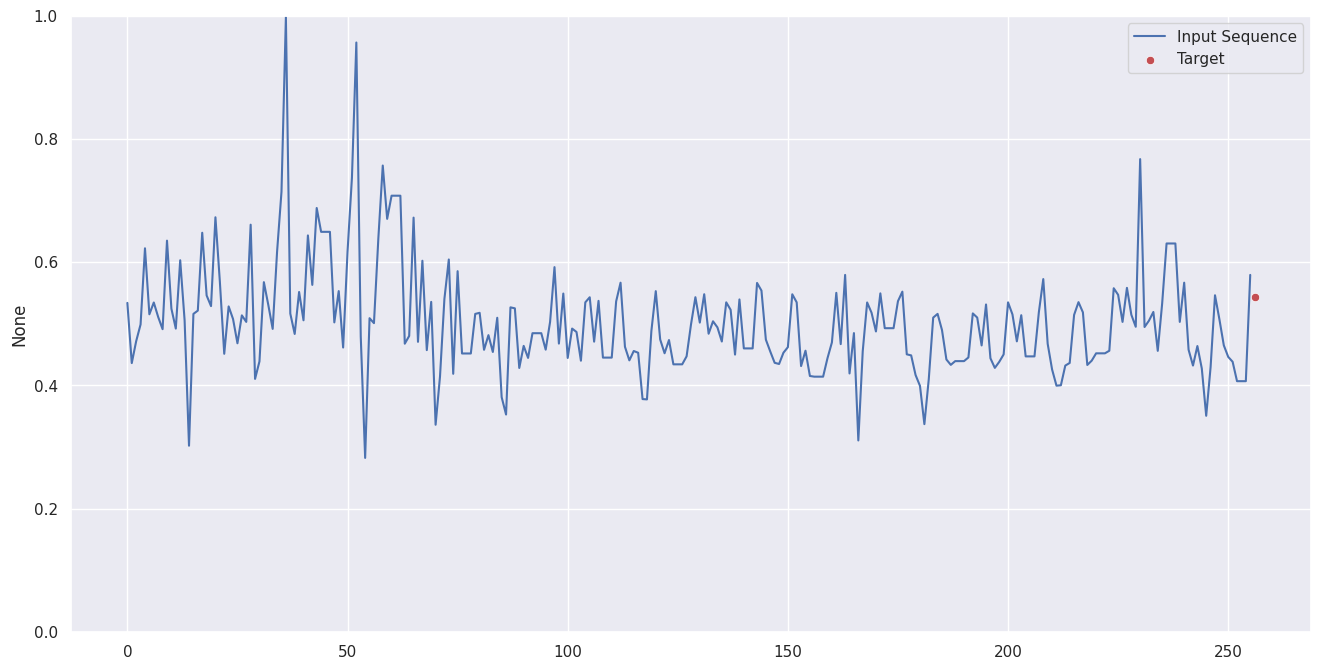

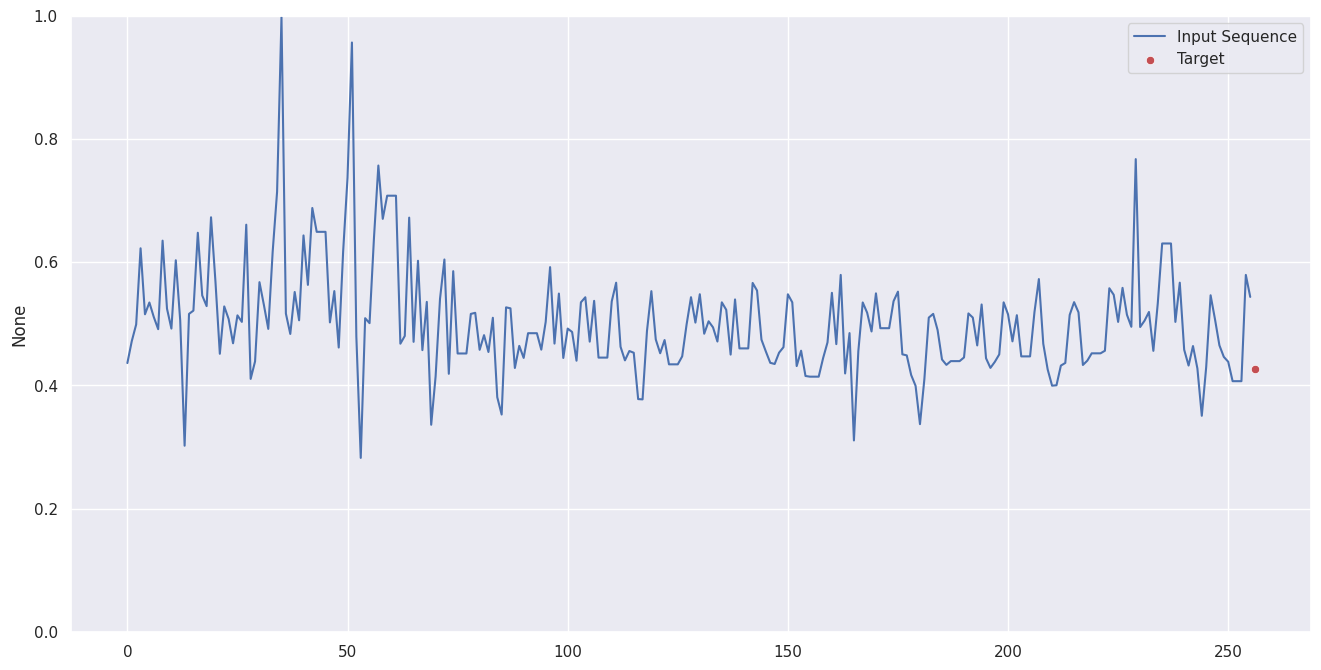

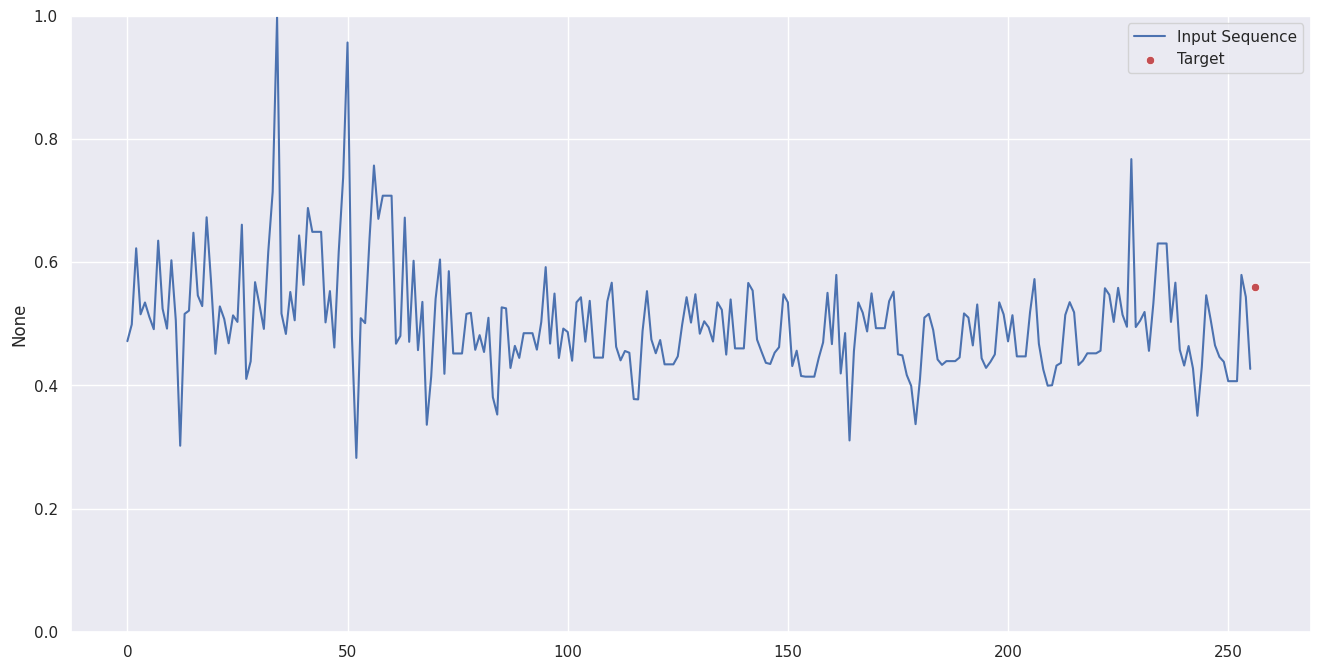

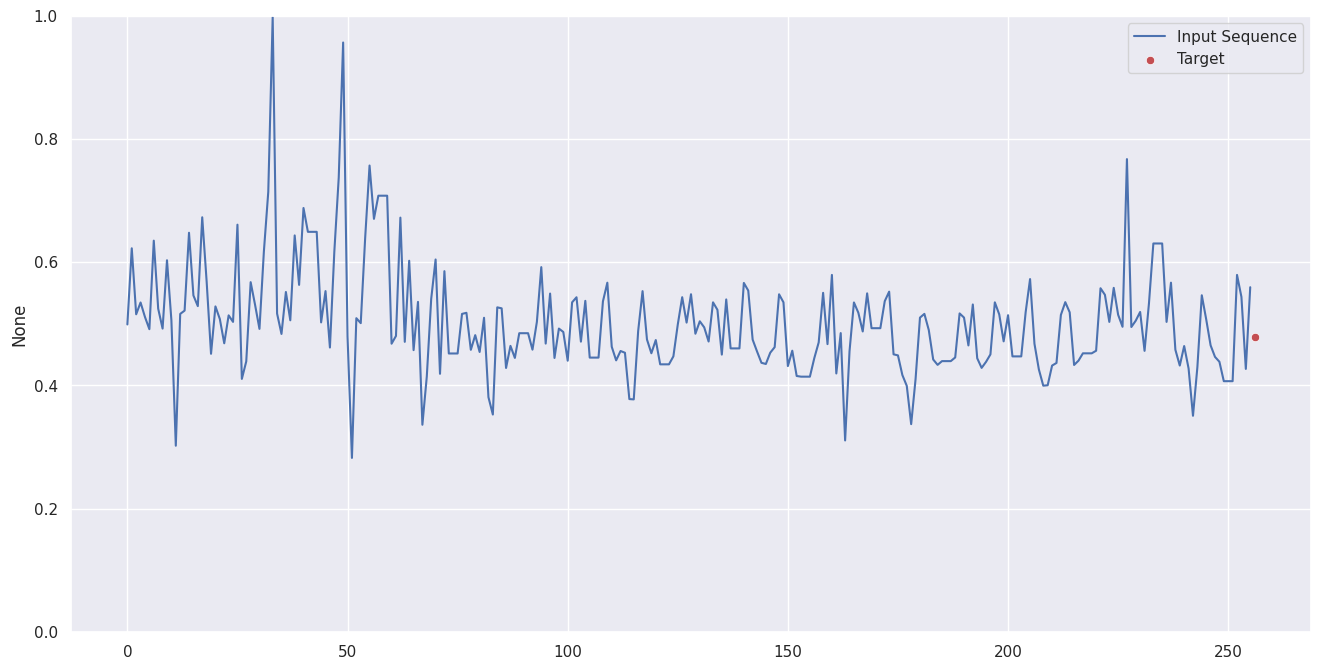

In [8]:
for i in range(5):
    plt.figure(figsize=(16,8))
    sample = SequenceDataset(train_data['PedestalValue'].values, seq_length)[i]
    sns.lineplot(x = np.arange(seq_length), y=sample[0],label = 'Input Sequence')
    sns.scatterplot(x=seq_length, y=[sample[1].item()], color = 'r', label='Target')
    plt.ylim(0,1)
    plt.show()

In [9]:
len(train_data)

2048

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Device : {device}")


# Test Parameters
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1
num_epochs = 1000

# Good Parameters
# input_size = 1
# hidden_size = 256
# num_layers = 2
# output_size = 1
# num_epochs = 1000


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        
        out = self.fc(out[:, -1, :])
        return out

Device : cuda:0


In [11]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device=device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())

# Training loop
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.unsqueeze(-1).to(device)  # Add input_size dimension
        y_batch = y_batch.unsqueeze(-1).to(device)  # Ensure correct shape
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')


 10%|█         | 100/1000 [00:49<07:25,  2.02it/s]

Epoch [100/1000], Loss: 0.0254


 20%|██        | 200/1000 [01:38<06:35,  2.02it/s]

Epoch [200/1000], Loss: 0.0237


 30%|███       | 300/1000 [02:27<05:46,  2.02it/s]

Epoch [300/1000], Loss: 0.0329


 40%|████      | 400/1000 [03:16<04:54,  2.04it/s]

Epoch [400/1000], Loss: 0.0235


 50%|█████     | 500/1000 [04:05<04:05,  2.04it/s]

Epoch [500/1000], Loss: 0.0208


 60%|██████    | 600/1000 [04:53<03:16,  2.04it/s]

Epoch [600/1000], Loss: 0.0180


 70%|███████   | 700/1000 [05:42<02:27,  2.04it/s]

Epoch [700/1000], Loss: 0.0157


 80%|████████  | 800/1000 [06:31<01:37,  2.04it/s]

Epoch [800/1000], Loss: 0.0170


 90%|█████████ | 900/1000 [07:19<00:46,  2.13it/s]

Epoch [900/1000], Loss: 0.0161


100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]

Epoch [1000/1000], Loss: 0.0123


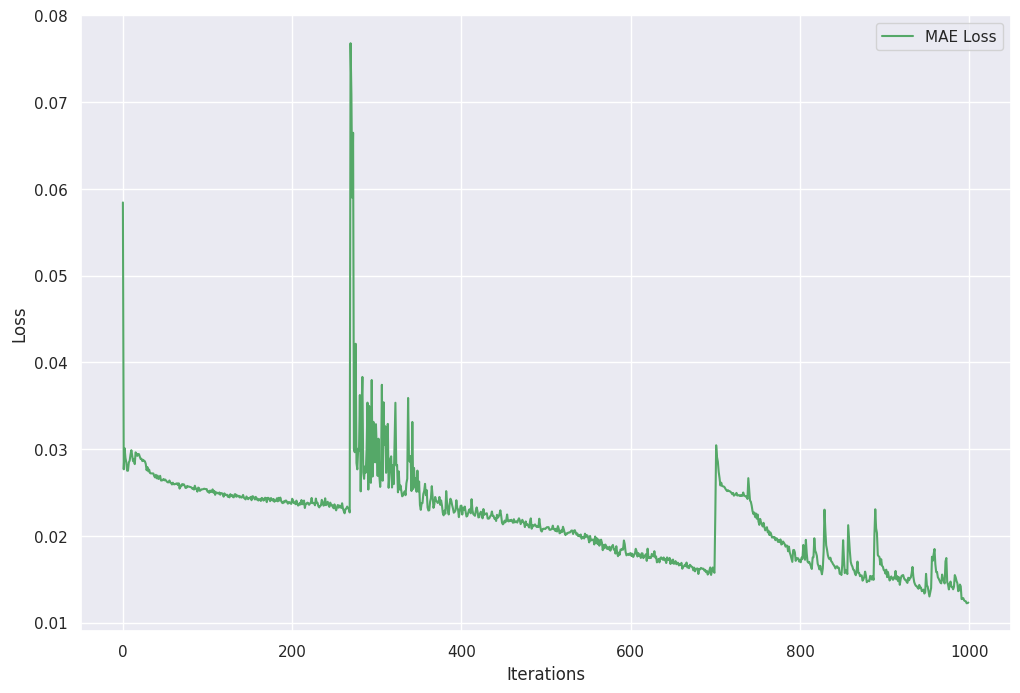

In [12]:
plt.figure(figsize=(12,8))
sns.lineplot(losses,color='g',label='MAE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [13]:
model.eval()


true_values = []
predictions = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.unsqueeze(-1).to(device)  # Add input_size dimension and move to GPU
        y_batch = y_batch.unsqueeze(-1).to(device) 
        preds = model(x_batch)

        # np.concatenate(preds.cpu().numpy())
        predictions.append(preds.cpu().numpy())  # Move predictions back to CPU for further processing
        true_values.append(y_batch.cpu().numpy())

true_values = np.concatenate(true_values)
predictions = np.concatenate(predictions)



In [14]:
template = test_data.iloc[256:][['Staves','Rows']].reset_index(drop=True)

analysis = template.copy()

analysis['Sequence'] = test_data.iloc[:256]['PedestalValue'].values

analysis['TrueValues'] = true_values
analysis['Predictions'] = predictions

analysis['Difference'] = analysis['TrueValues'] - analysis['Predictions']

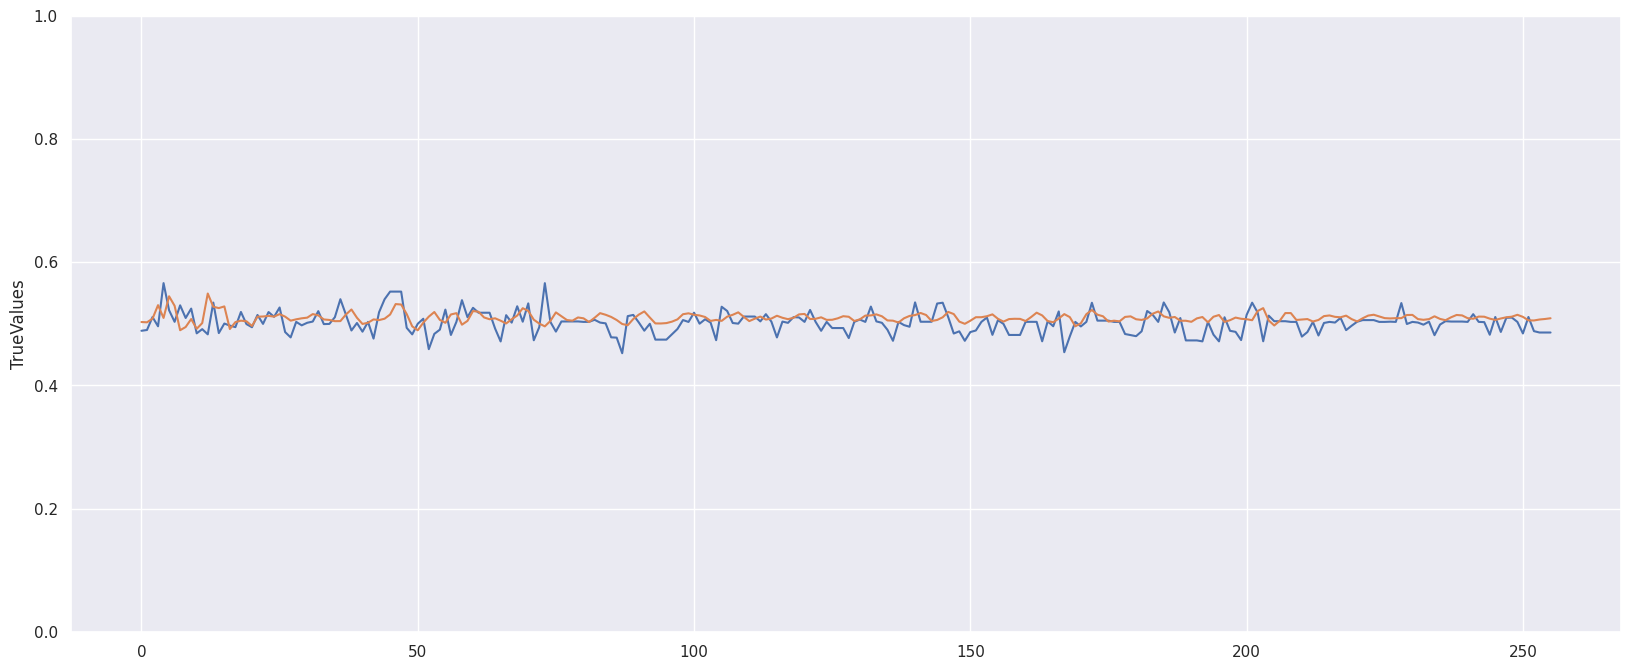

In [15]:
plt.figure(figsize=(20,8))
sns.lineplot(analysis['TrueValues'])
sns.lineplot(analysis['Predictions'])
plt.ylim(0,1)
plt.show()

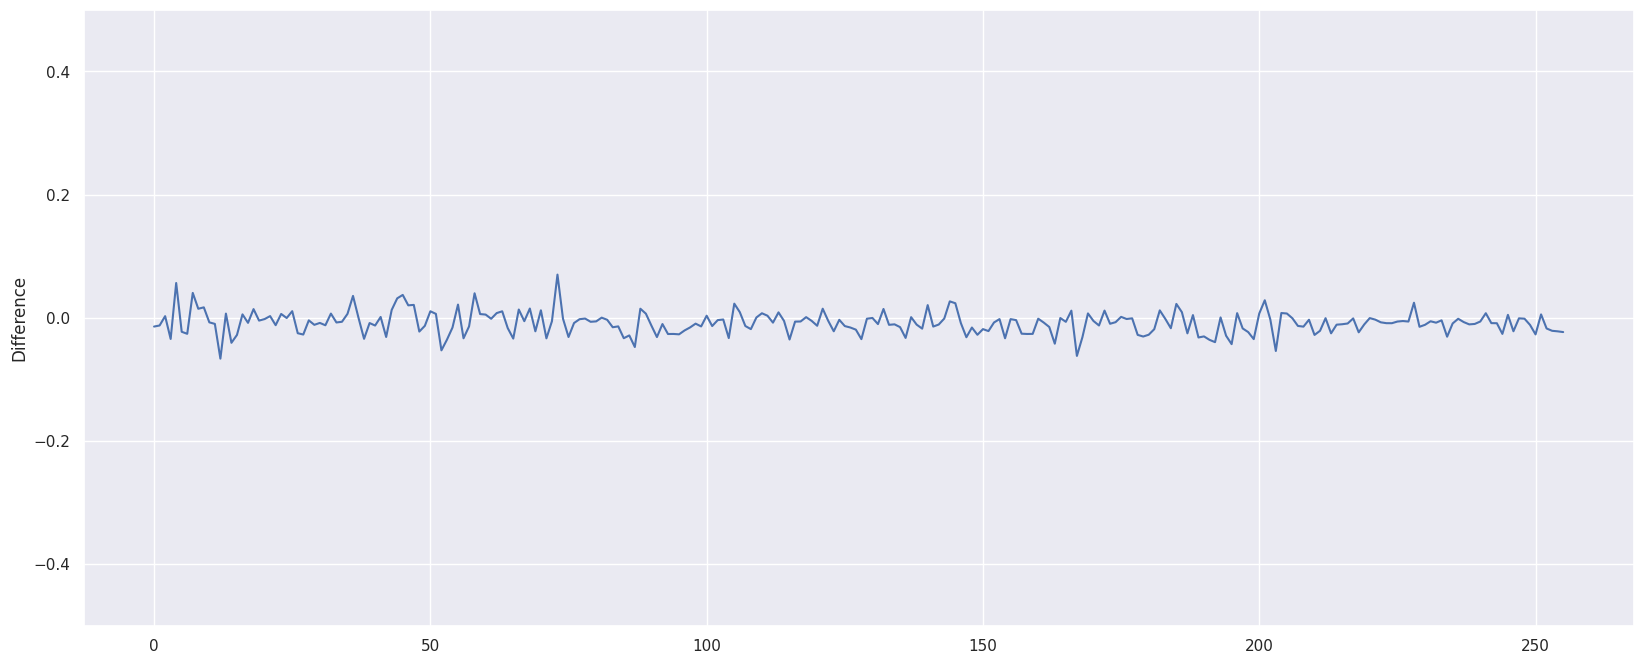

In [16]:
plt.figure(figsize=(20,8))
sns.lineplot(analysis['Difference'])
plt.ylim(-0.5,0.5)
plt.show()

In [17]:
train_data.index.max()

2047

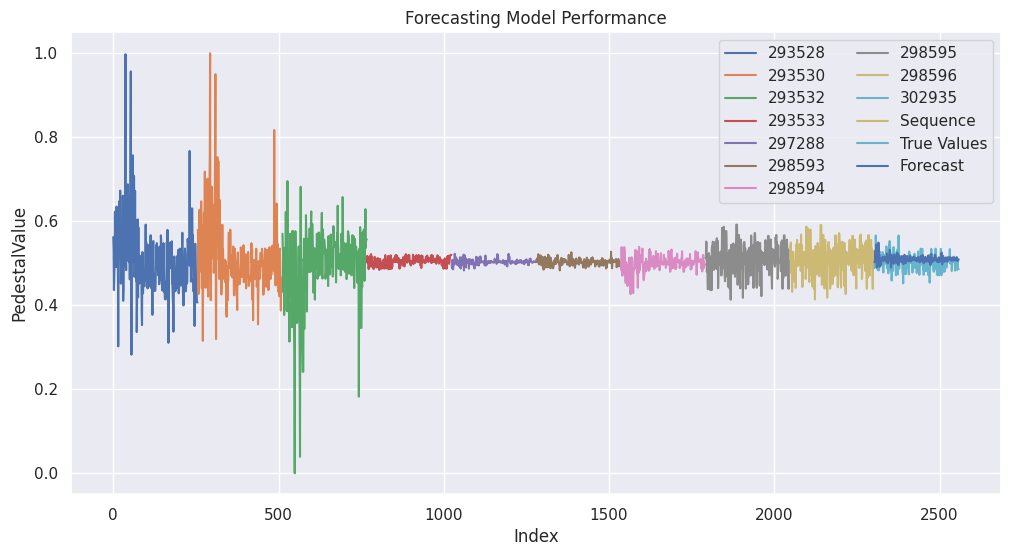

In [18]:
# analysis['True'] = scaler.inverse_transform(true_values.reshape(-1,1))
# analysis['Pred'] = scaler.inverse_transform(predictions.reshape(-1,1))
plt.figure(figsize=(12, 6))
sns.lineplot(x = train_data.index, y =train_data['PedestalValue'],hue=train_data['RunNumber']) #train_data for non-scaled data
sns.lineplot(x=pd.RangeIndex(start=train_data.index.max(), stop=train_data.index.max()+256, step=1), y=analysis['Sequence'], label='Sequence')
sns.lineplot(x=pd.RangeIndex(start=train_data.index.max()+256, stop=train_data.index.max()+512, step=1), y=analysis['TrueValues'], label='True Values')
sns.lineplot(x=pd.RangeIndex(start=train_data.index.max()+256, stop=train_data.index.max()+512, step=1), y=analysis['Predictions'], label='Forecast')
plt.xlabel('Index')
plt.ylabel('PedestalValue')
plt.title('Forecasting Model Performance')
plt.legend(ncols=2)
plt.show()

In [19]:
data_true = data_preparation_for_ut(data_ = analysis, feature='TrueValues')
data_pred = data_preparation_for_ut(data_ = analysis, feature='Predictions')
data_diff = data_preparation_for_ut(data_ = analysis, feature='Difference')

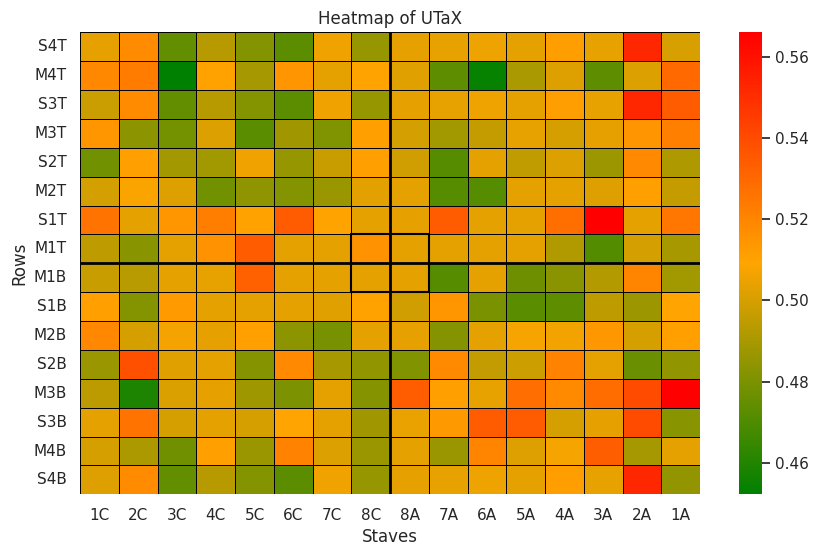

In [20]:
ut_plot(data_true,show_fig=True)

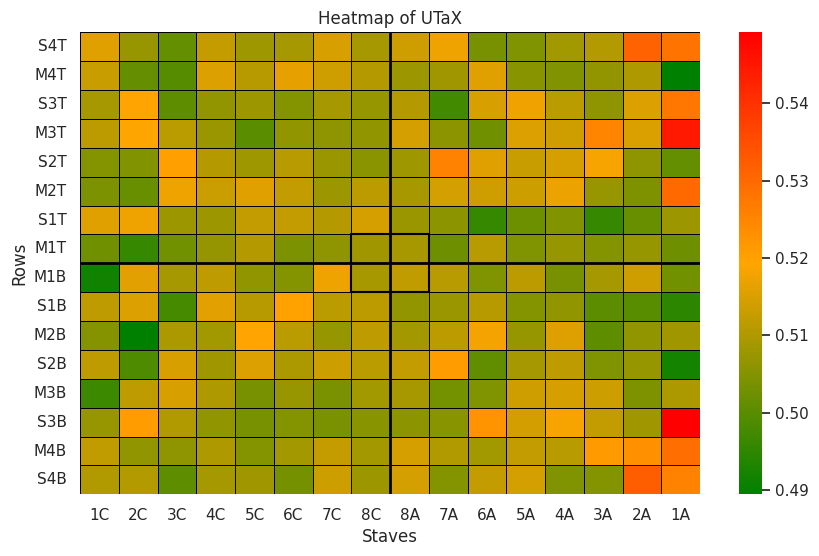

In [21]:
ut_plot(data_pred,show_fig=True)

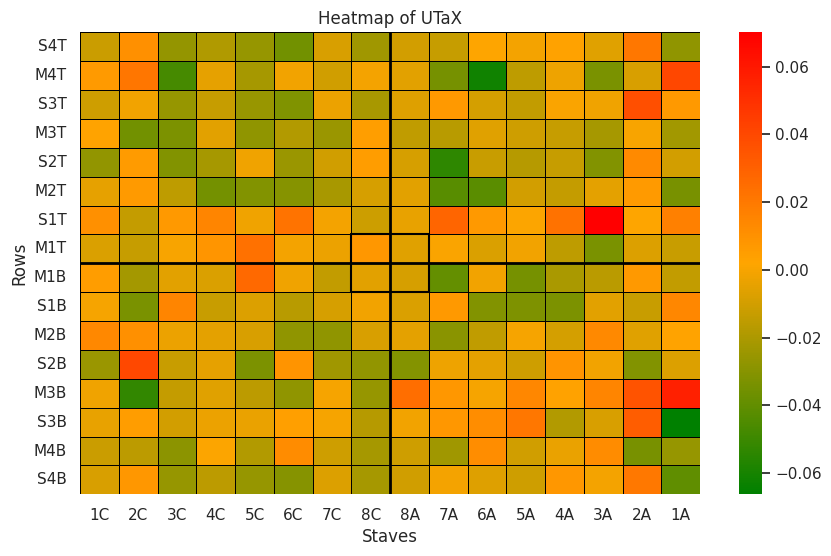

In [22]:
ut_plot(data_diff,show_fig=True,vmin_vmax_scaled=False)